# SNR TARGETTING EACH VALUE SEPERATELY

9999	

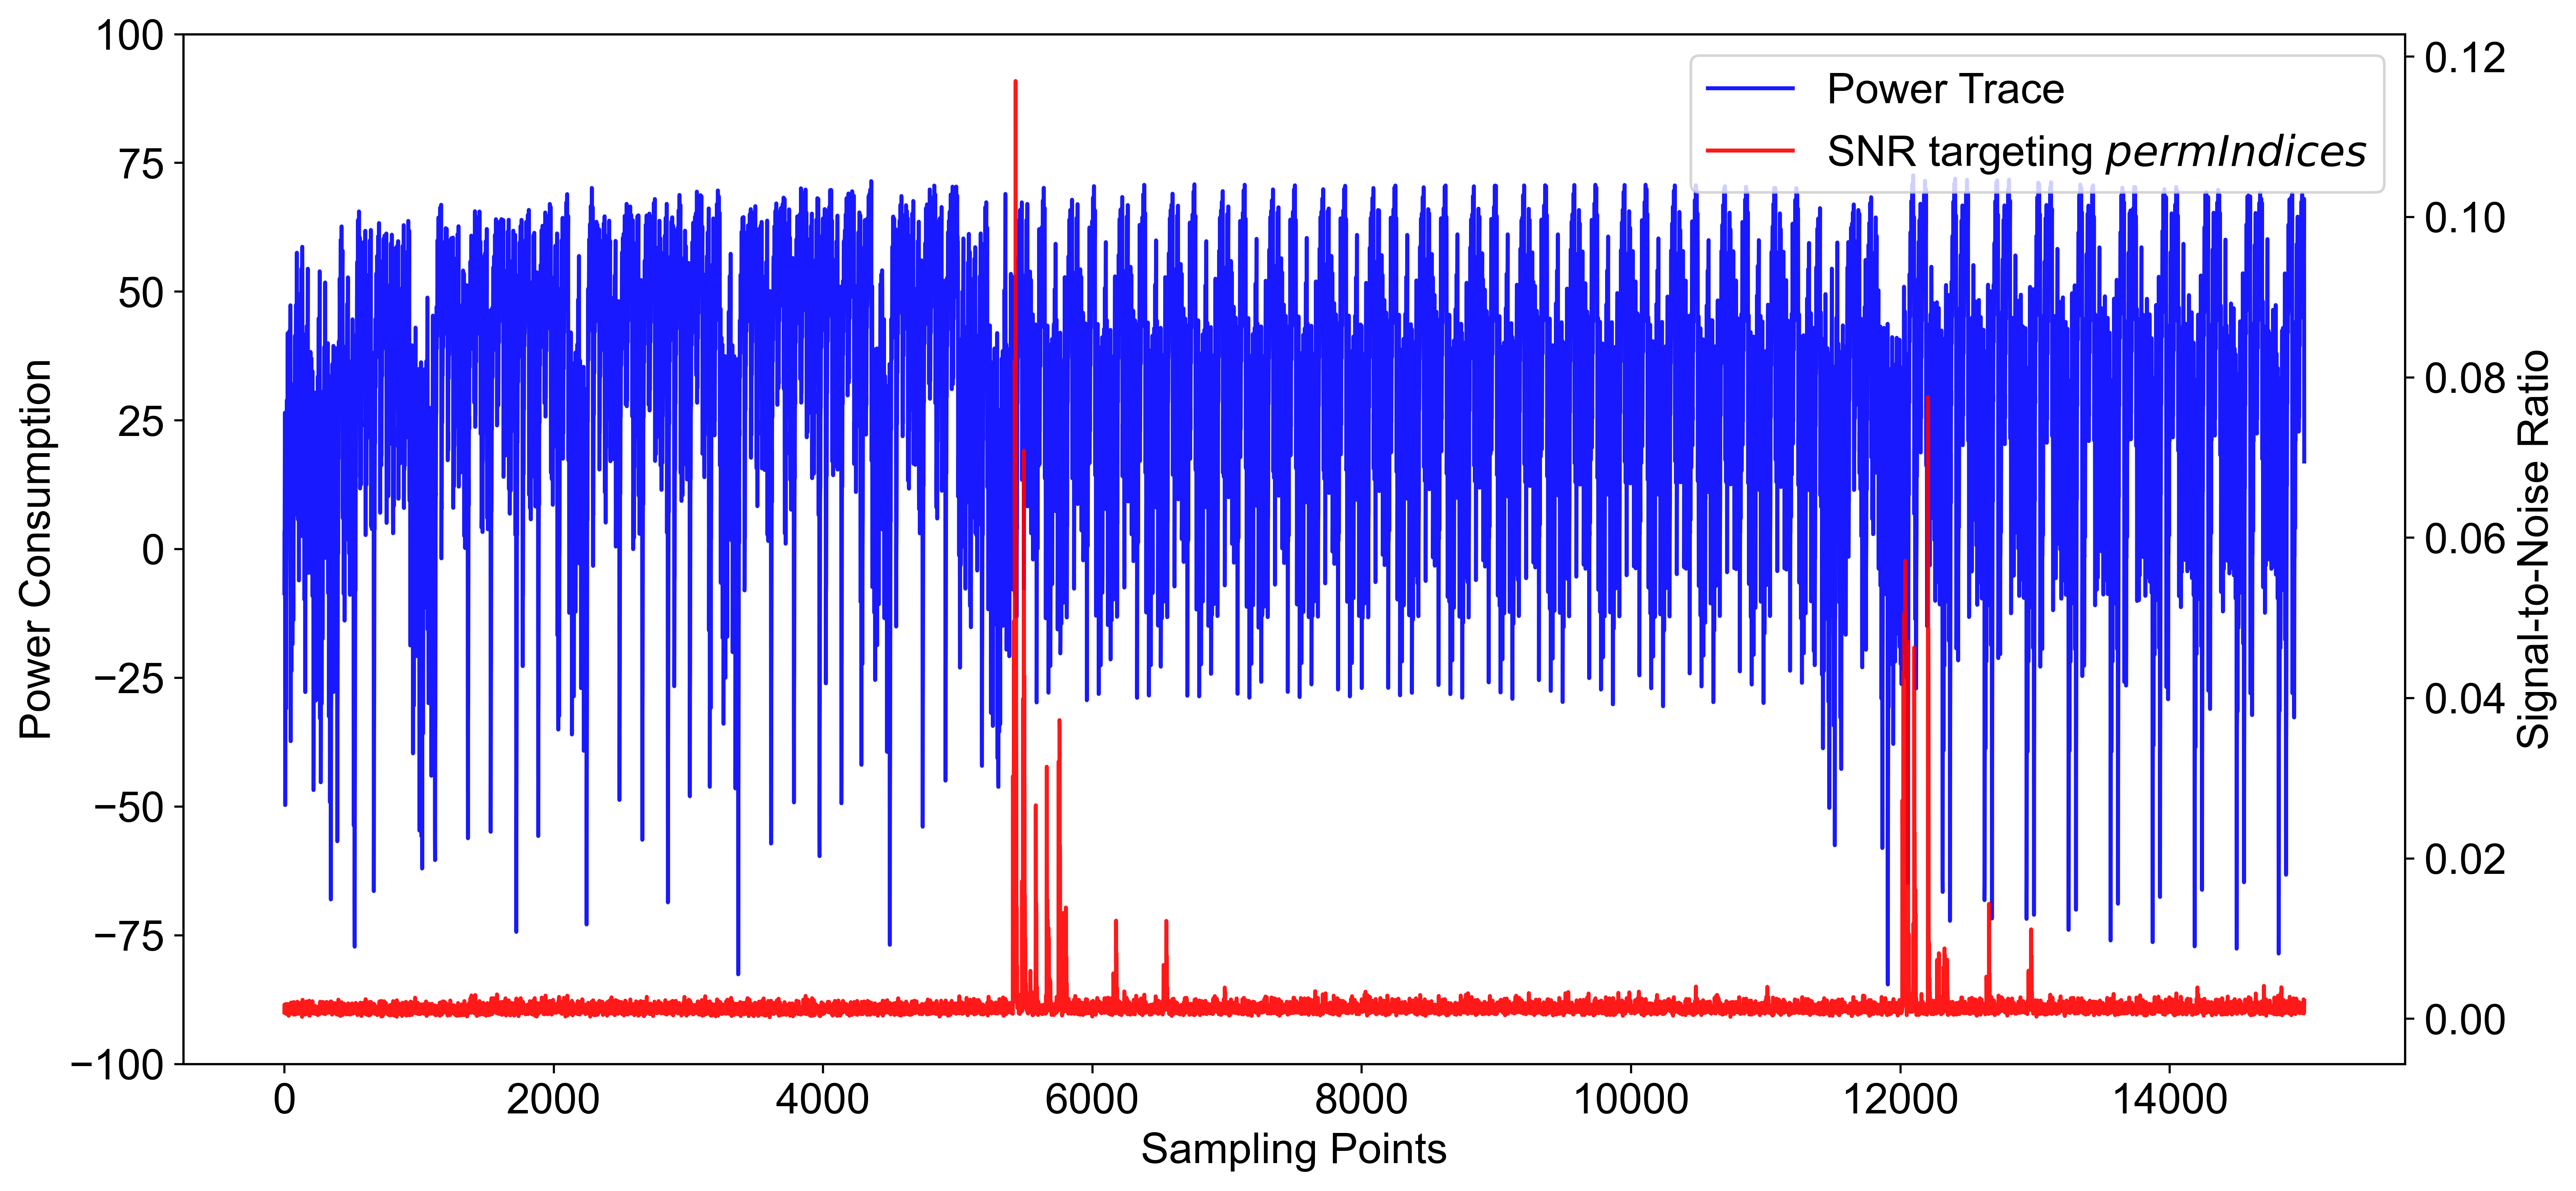

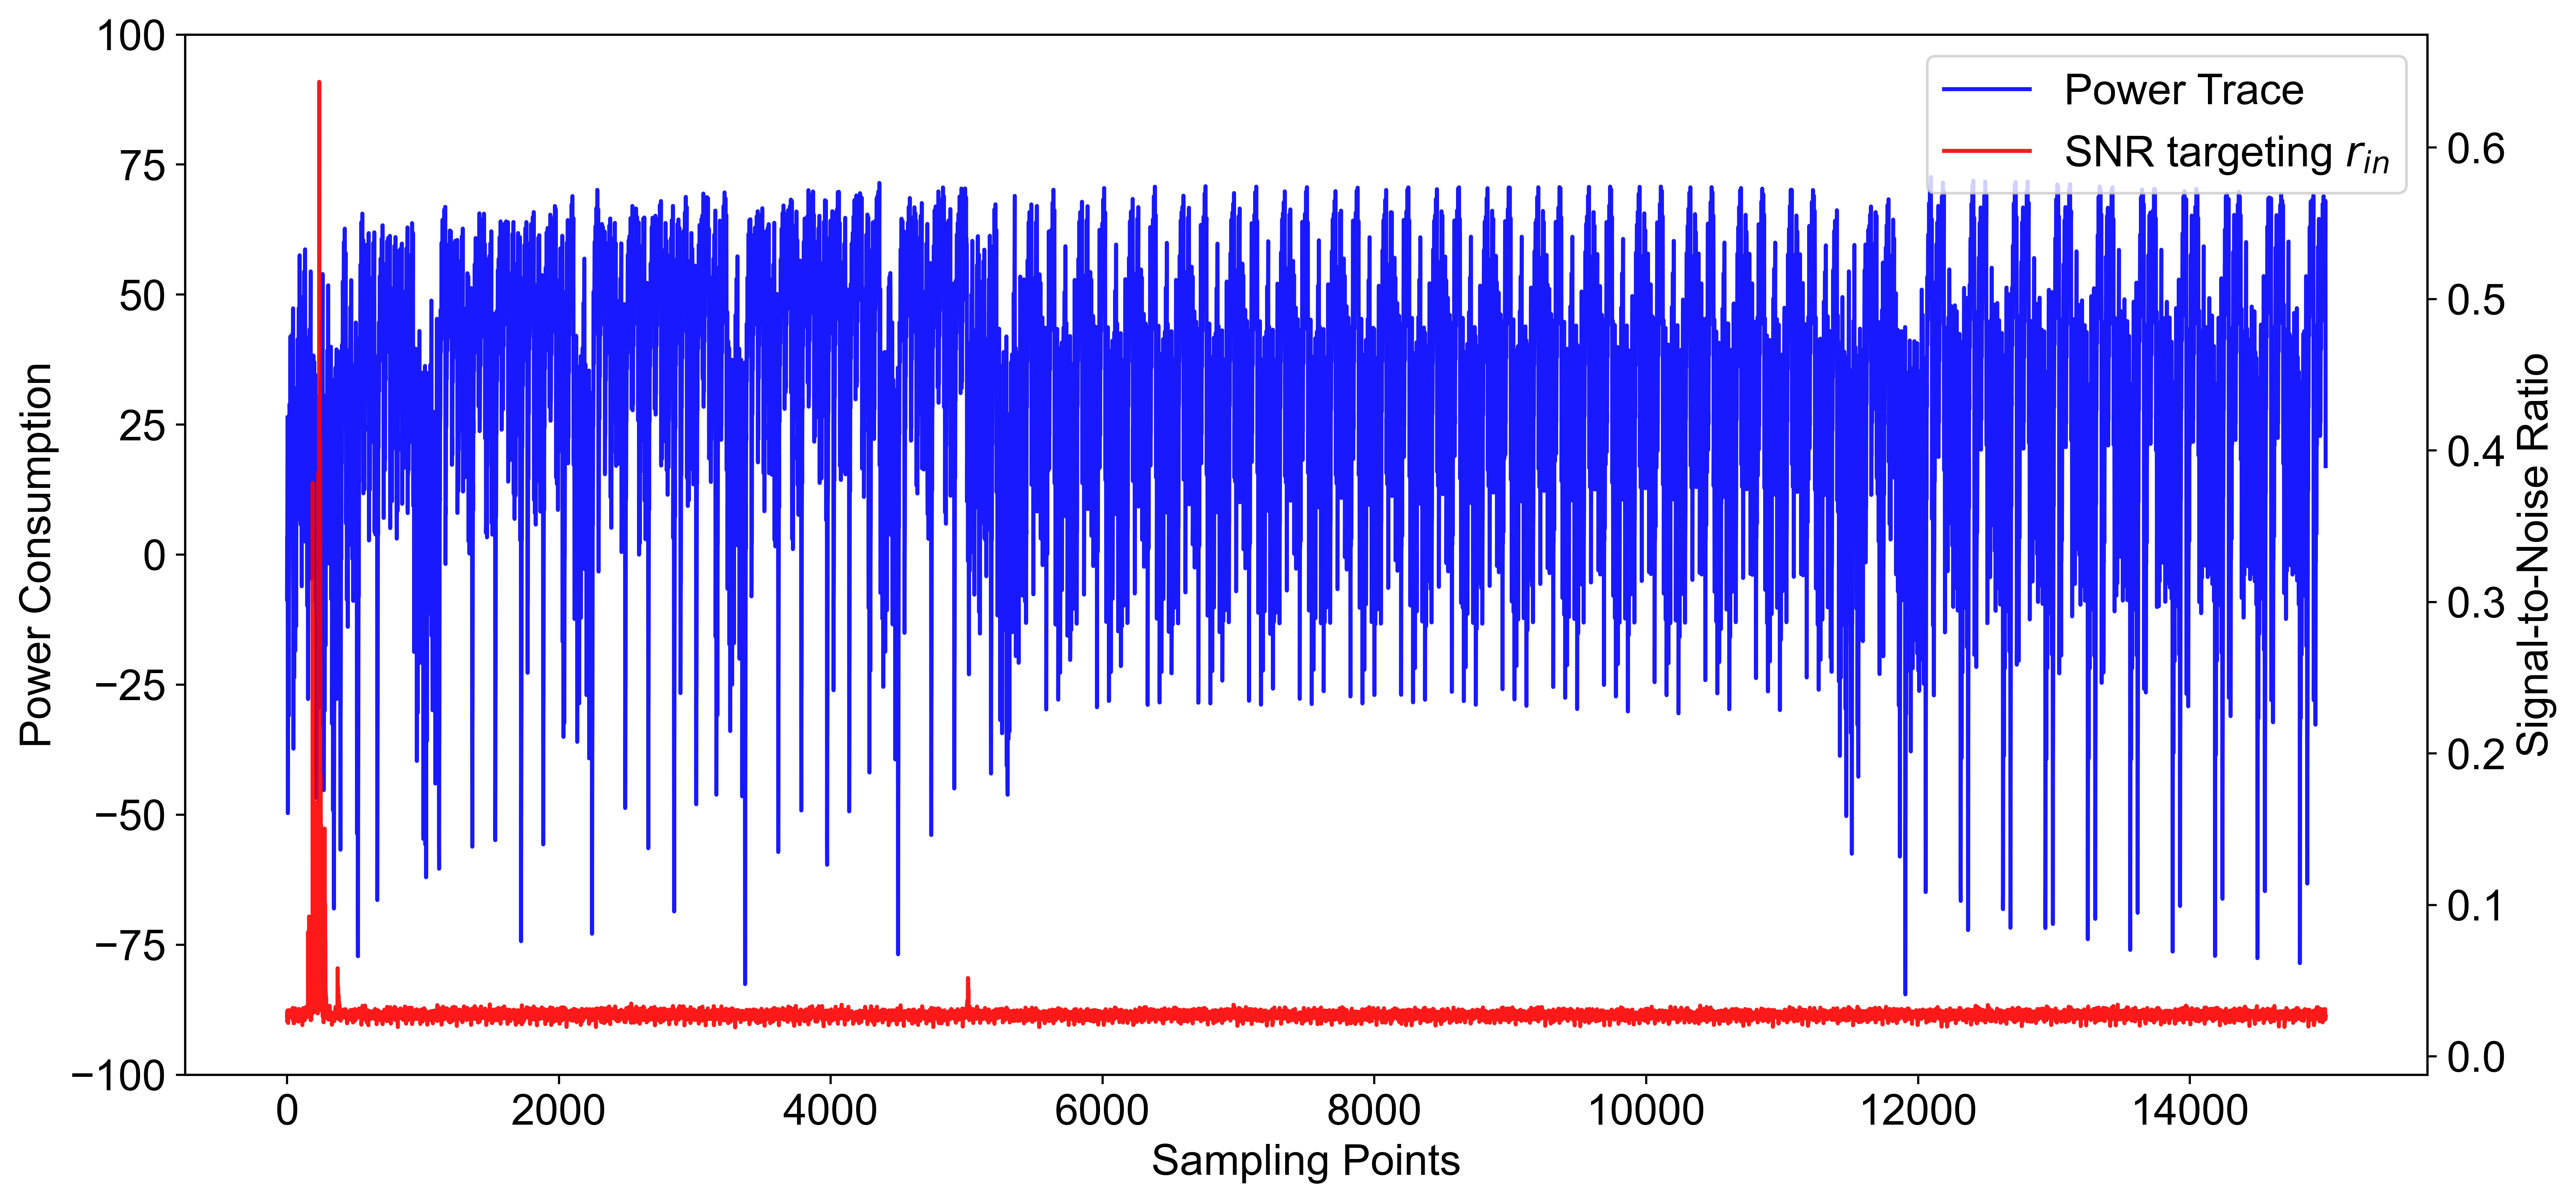

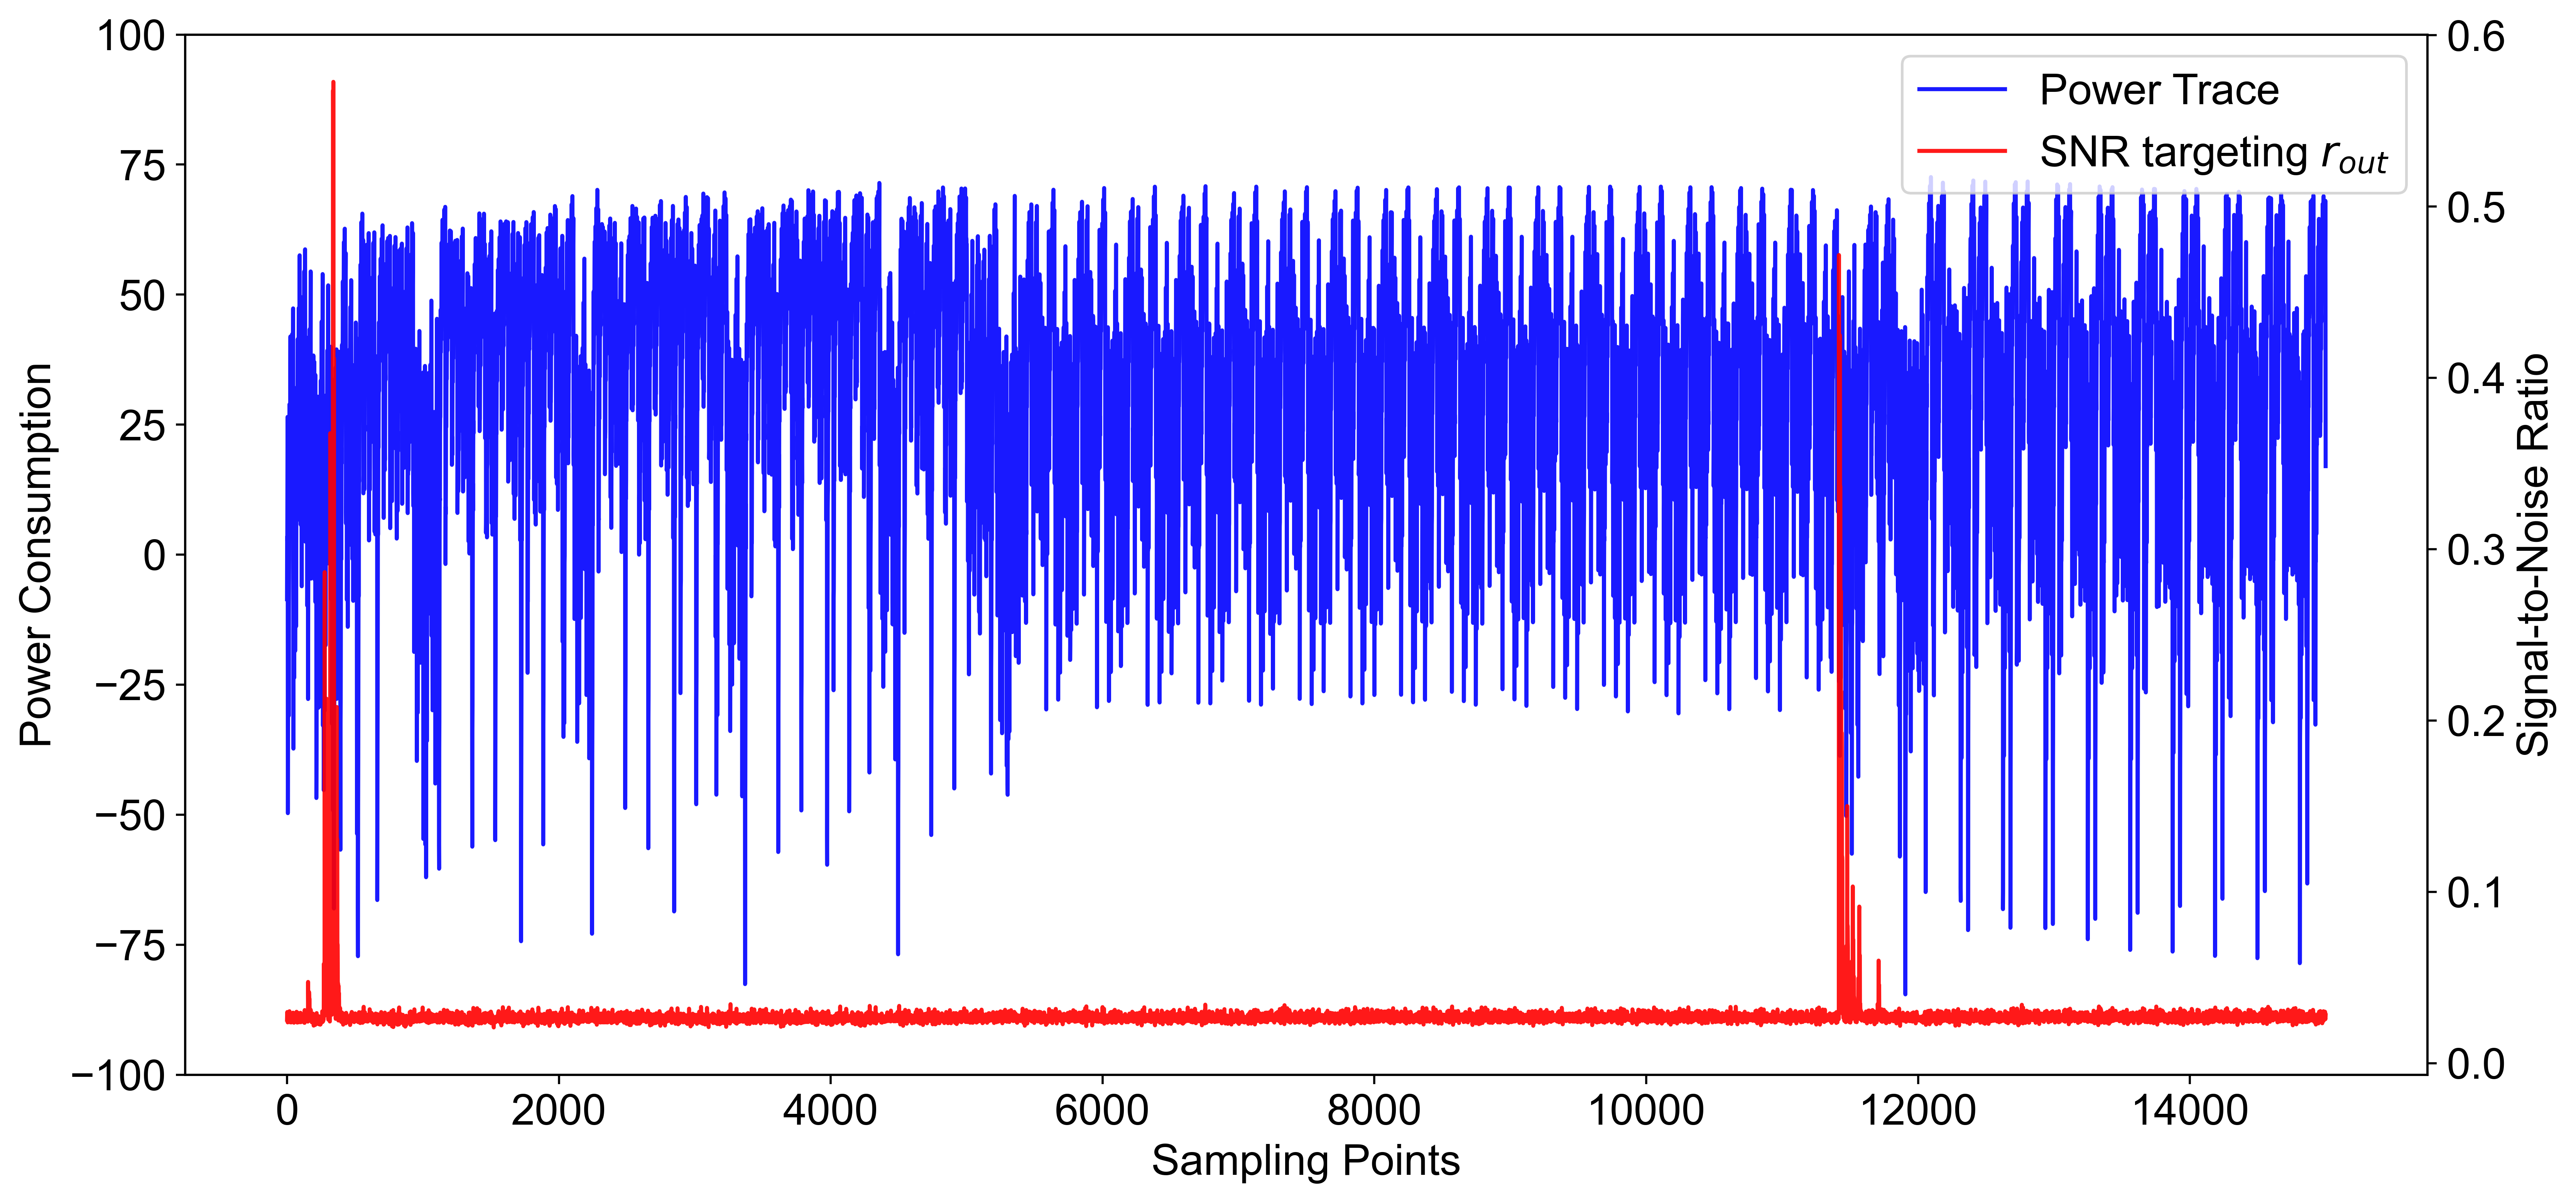

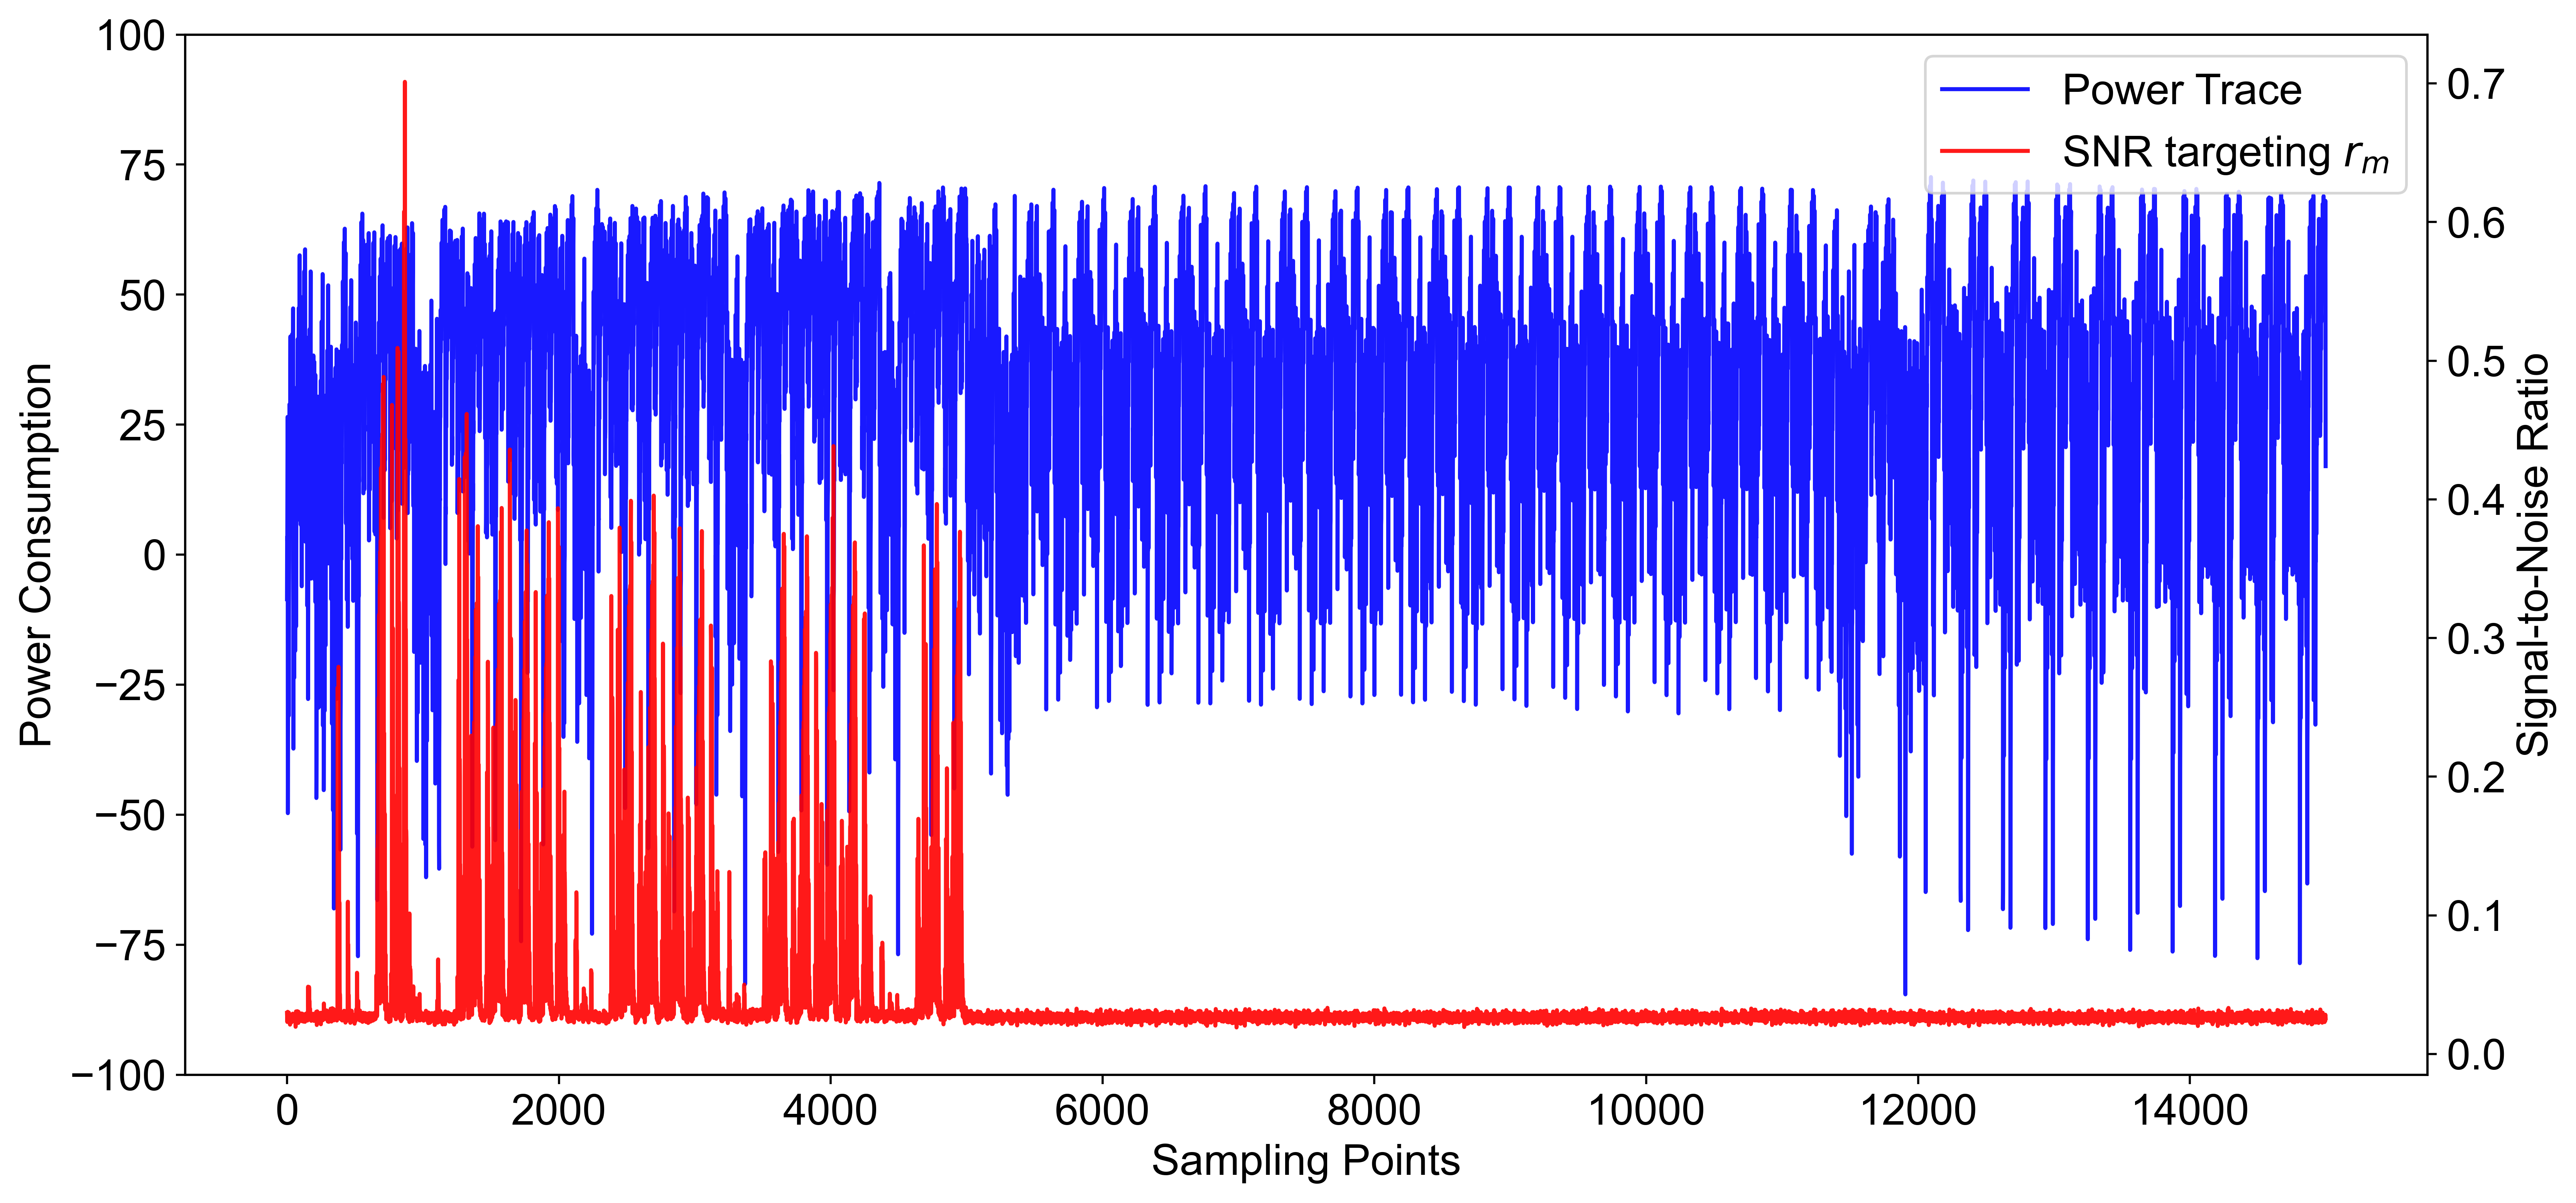

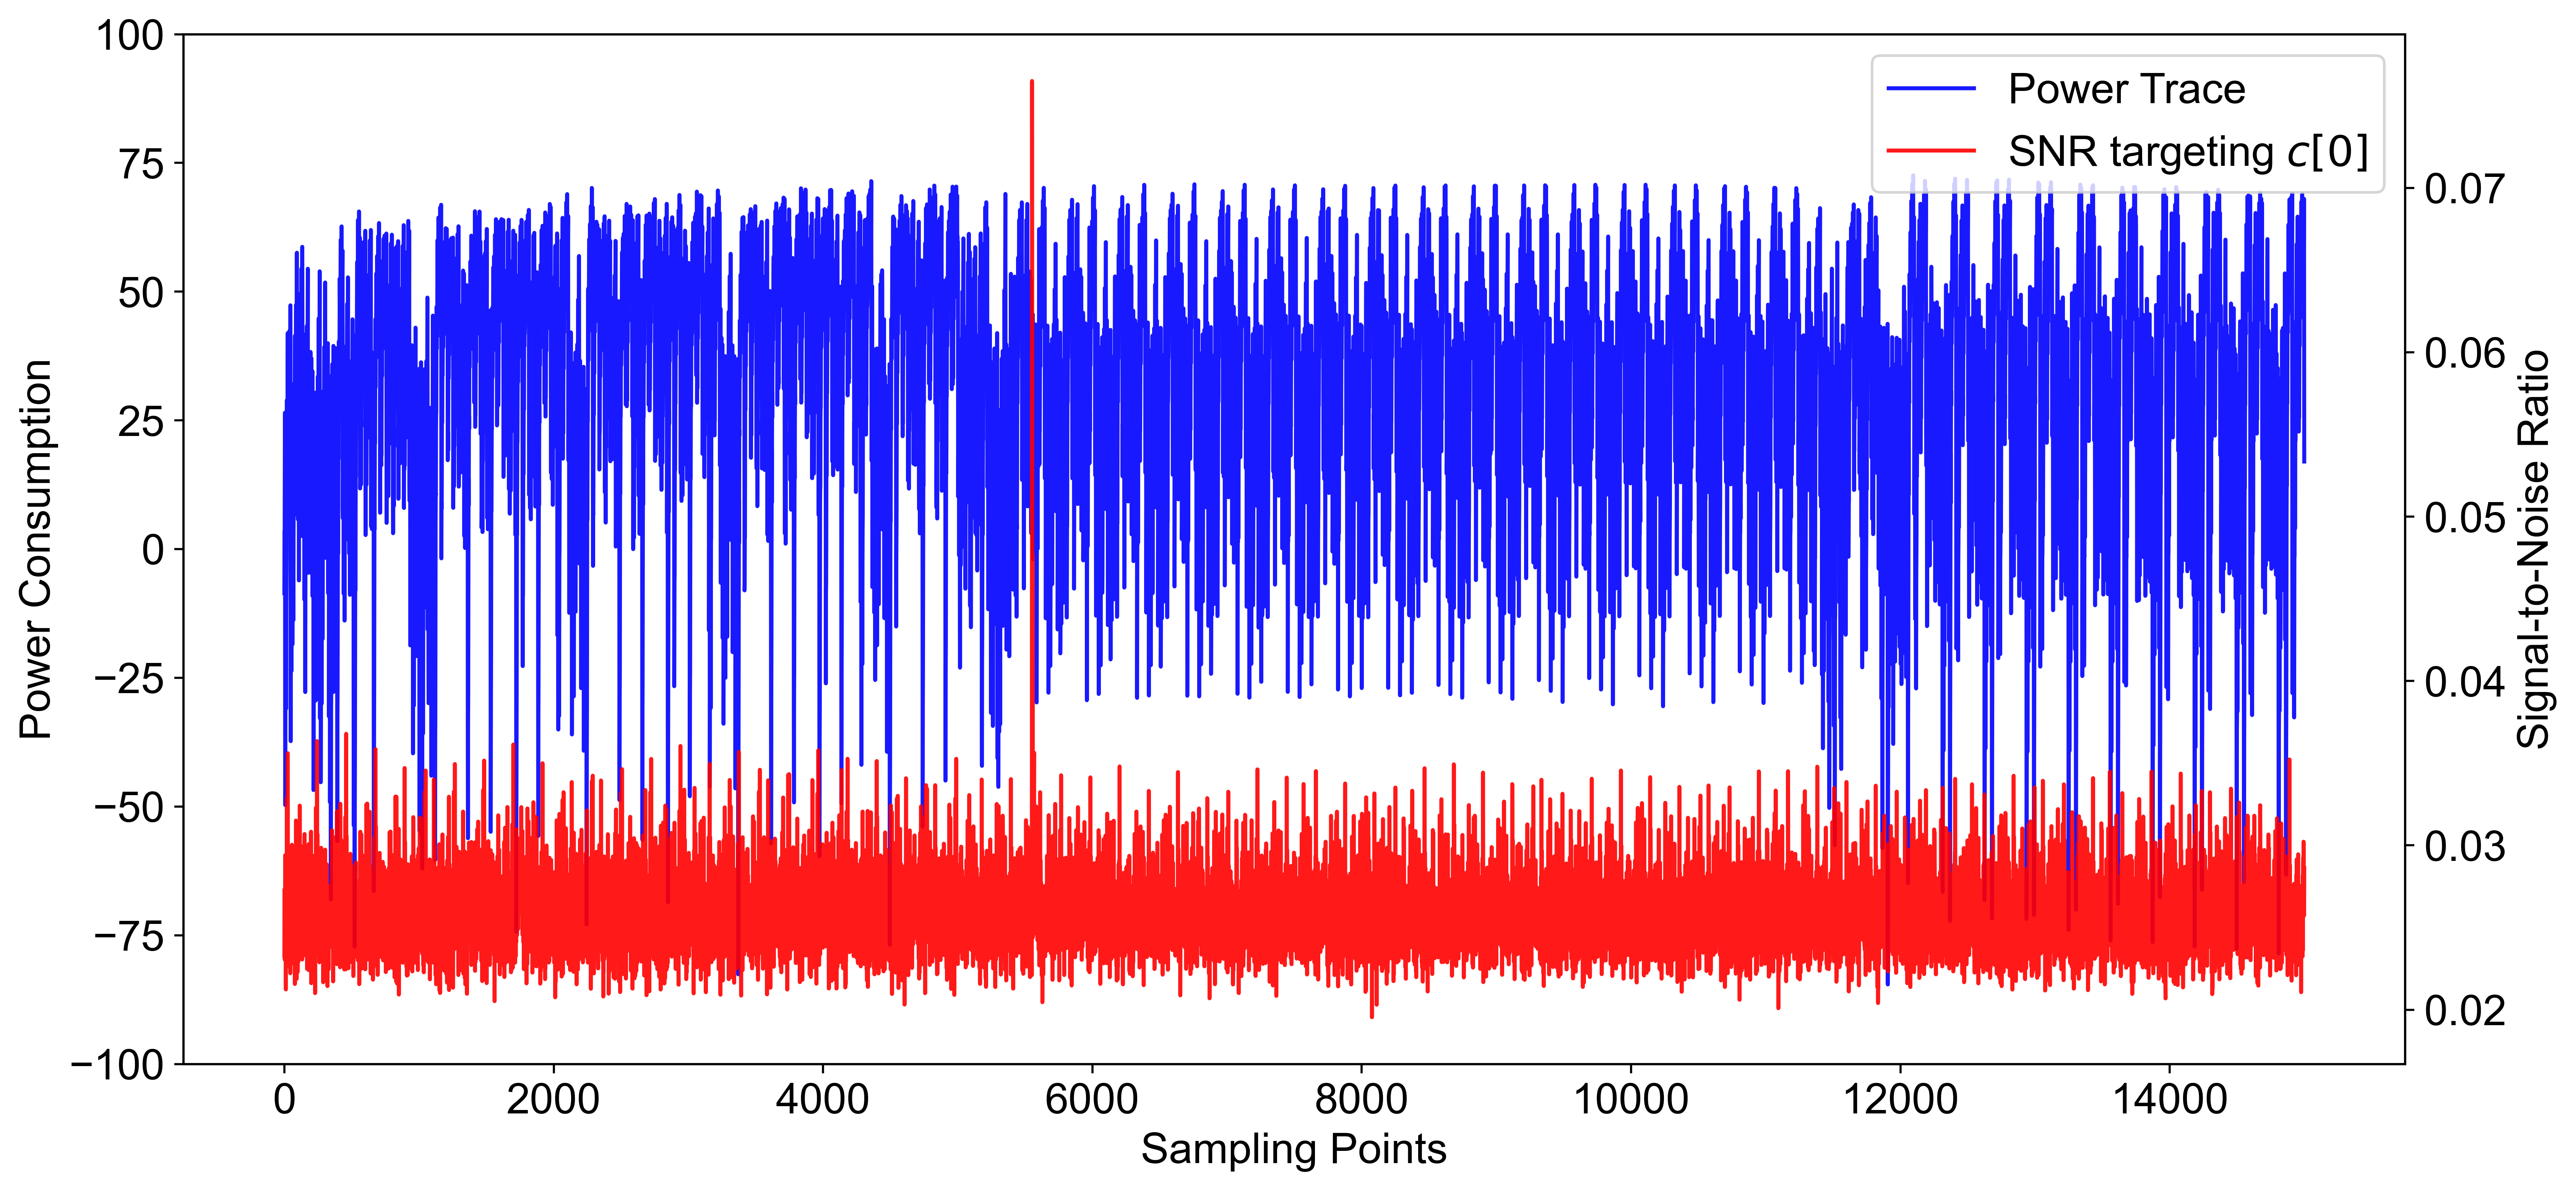

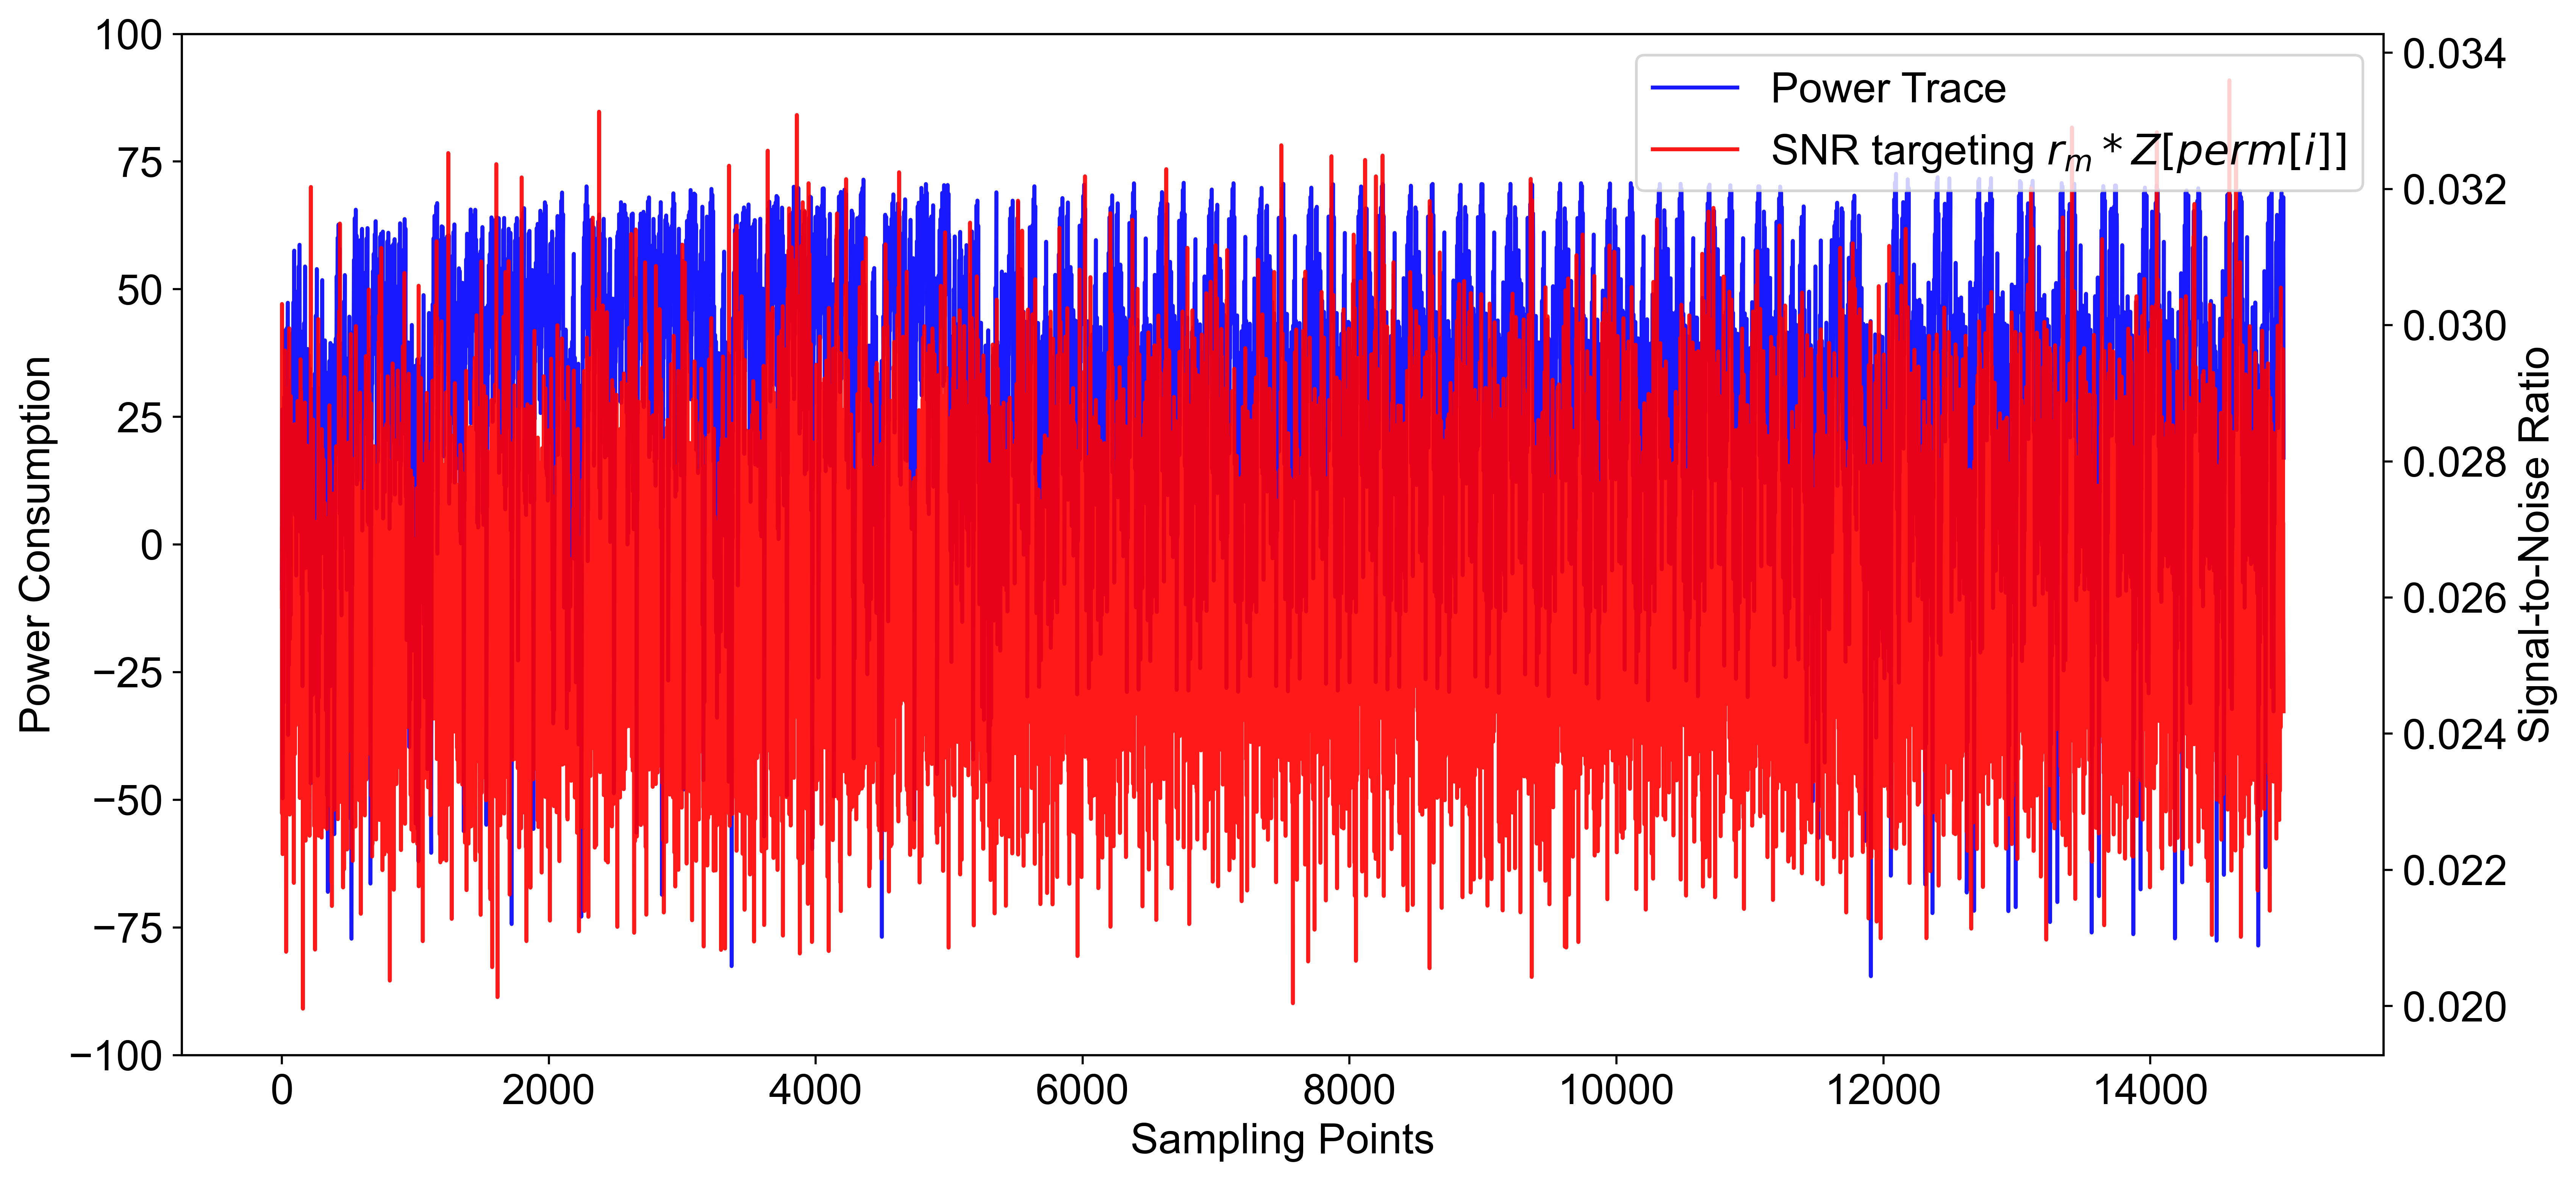

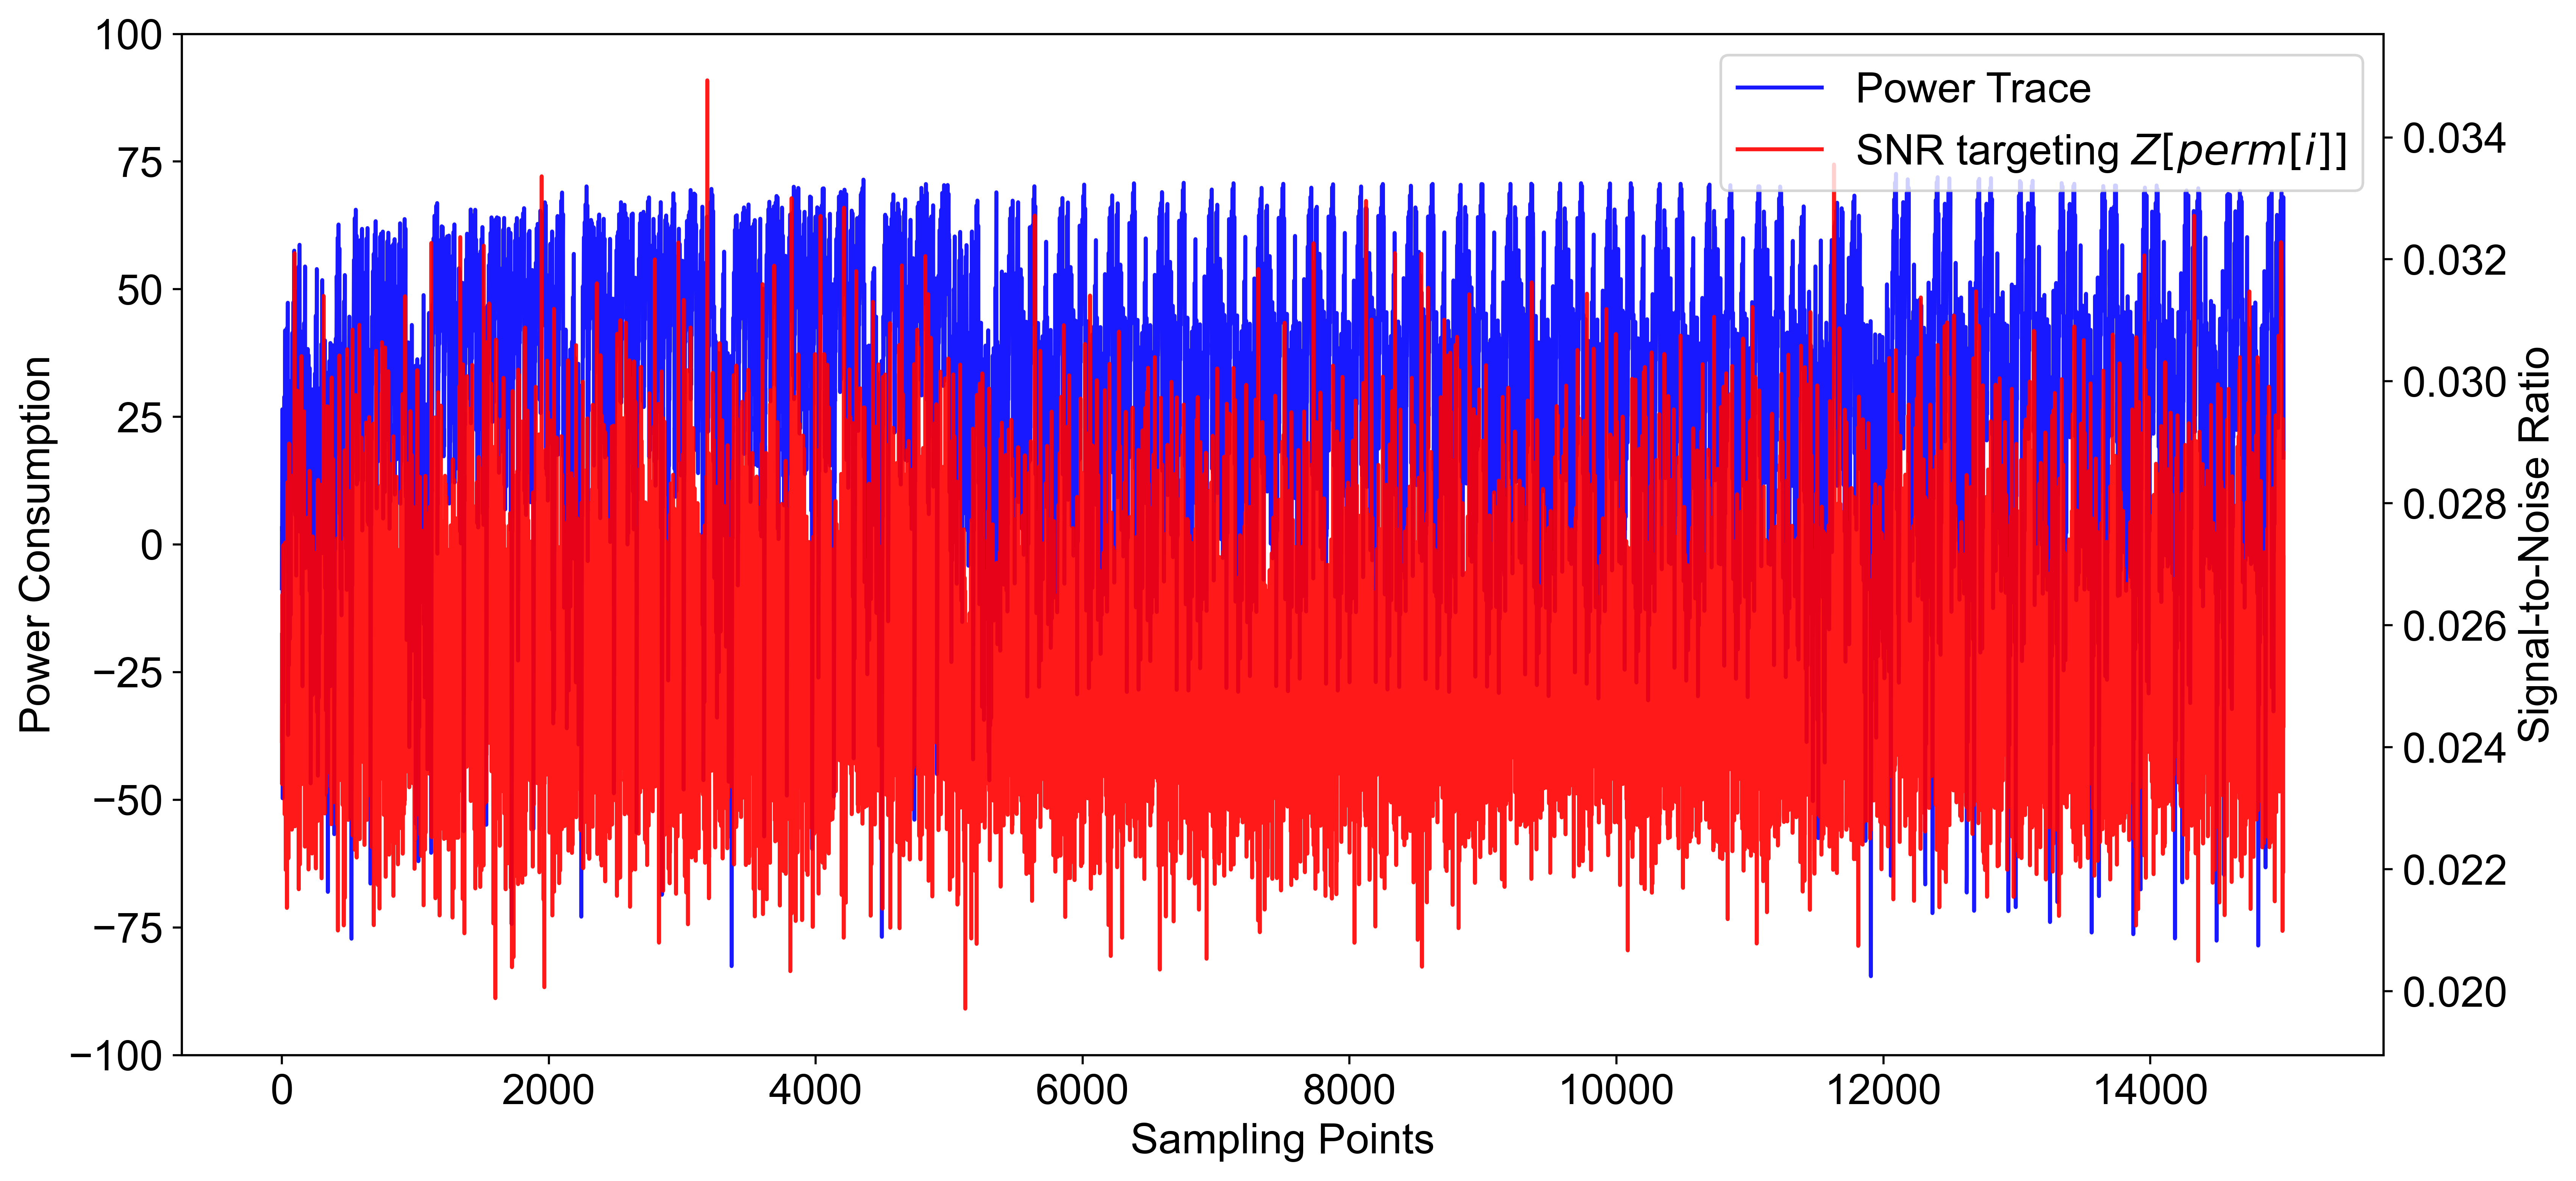

max SNR_c: 0.07650343885714773
(array([5552, 5553]),)
max SNR for r_out: 0.5727718948568803
(array([  338,   339,   341,   342,   343,   345, 11418, 11419, 11421,
       11425]),)
max SNR for rm: 0.701092019046882
(array([813, 820, 861, 867, 868]),)


In [14]:
import sys
import os

import h5py
import matplotlib.pyplot as plot
import numpy as np
import palettable

from Setup import generatePermIndices, RunningSignalToNoiseRatio, multiplyGF256, SBOX, RunningMean


data_filename = "ascadv2-extracted.h5"
file_pointer = h5py.File(data_filename, "r")

trace_data = file_pointer["Profiling_traces"]["traces"]
metadata = file_pointer["Profiling_traces"]["metadata"]

def retrieve_data(index, byte_index=0):
    
    trace_instance = trace_data[index]
    mask_values = metadata[index]["masks"]
    key_value, plaintext_value = metadata[index]["plaintext"], metadata[index]["key"]
    substitution = SBOX[key_value ^ plaintext_value]
    indices = generatePermIndices(np.arange(16), *mask_values[:4])
    
    r_input, r_output, r_mask = (mask_values[16], 
                                 mask_values[17], 
                                 mask_values[18])
    
    calc_value = multiplyGF256(r_mask, substitution[indices[byte_index]]) ^ r_output
    calc1 = multiplyGF256(r_mask, substitution[indices[byte_index]])
    calc2 = substitution[indices[byte_index]]
    return trace_instance, indices, r_input, r_output, r_mask, calc_value, calc1, calc2

snr_calculators = [
    RunningSignalToNoiseRatio(n_classes=n) for n in (16, 256, 256, 255, 256, 256, 256)
]
snr_indices_calculator, snr_r_input_calculator, snr_r_output_calculator, snr_r_mask_calculator, \
snr_calc_calculator, snr_calc1_calculator, snr_calc2_calculator = snr_calculators

mean_trace_calculator = RunningMean()  

for index, (trace_instance, indices, r_input, r_output, r_mask, calc_value, calc1, calc2) in \
        enumerate(retrieve_data(i, byte_index=0) for i in range(10000)):
    
    sys.stdout.write(f"\r{index}\t")

    snr_indices_calculator.update(trace_instance, indices[0])
    snr_r_input_calculator.update(trace_instance, r_input)
    snr_r_output_calculator.update(trace_instance, r_output)
    snr_r_mask_calculator.update(trace_instance, r_mask - 1)
    snr_calc_calculator.update(trace_instance, calc_value)
    snr_calc1_calculator.update(trace_instance, calc1)
    snr_calc2_calculator.update(trace_instance, calc2)
    mean_trace_calculator.update(trace_instance)

    del trace_instance, indices, r_input, r_output, r_mask, calc_value, calc1, calc2

snr_indices, snr_r_input, snr_r_output, snr_r_mask, snr_calc, snr_calc1, snr_calc2 = \
    (calc() for calc in snr_calculators)

final_trace_mean = mean_trace_calculator()

target_snr_values = [snr_indices, snr_r_input, snr_r_output, snr_r_mask, snr_calc, snr_calc1, snr_calc2]
target_strings = ["$permIndices$", "$r_{in}$", "$r_{out}$", "$r_{m}$", "$c[0]$", "$r_m*Z[perm[i]]$", "$Z[perm[i]]$"]

plot.rcParams['figure.figsize'] = [16, 4]
plot.rc('font', family='Arial', size='16')

for index, (snr_value, target_string) in enumerate(zip(target_snr_values, target_strings)):
    figure_instance, ax = plot.subplots(figsize=(15, 7), dpi=500)
    trace_points = np.arange(final_trace_mean.shape[0])
    ax.set_xlabel("Sampling Points")
    ax.set_ylabel("Power Consumption")
    ax.set_ylim(-100, 100)
    
    line_0 = ax.plot(trace_points, final_trace_mean, alpha=0.9, label="Power Consumption Trace", color="blue")
    ax_right = ax.twinx()
    ax_right.set_ylabel("Signal-to-Noise Ratio")
    line_1 = ax_right.plot(trace_points, snr_value, alpha=0.9, label=f"SNR targeting {target_string}", color="red")
    
    plot.legend([line_0[0], line_1[0]], ["Power Trace", f"SNR targeting {target_string}"], fancybox=True, loc="upper right")
    plot.savefig(f"SNR_{index}.jpg")
    plot.show()


max_snr_calc = max(snr_calc)
print(f'max SNR_c: {max_snr_calc}')
print(np.where(snr_calc > (max_snr_calc / 1.5)))

max_snr_r_output = max(snr_r_output)
print(f'max SNR for r_out: {max_snr_r_output}')
print(np.where(snr_r_output > (max_snr_r_output / 1.5)))

max_snr_r_mask = max(snr_r_mask)
print(f'max SNR for rm: {max_snr_r_mask}')
print(np.where(snr_r_mask >= (max_snr_r_mask / 1.4)))


# COMBINED OVERALL SIGNAL TO NOISE RATIO 


99999	

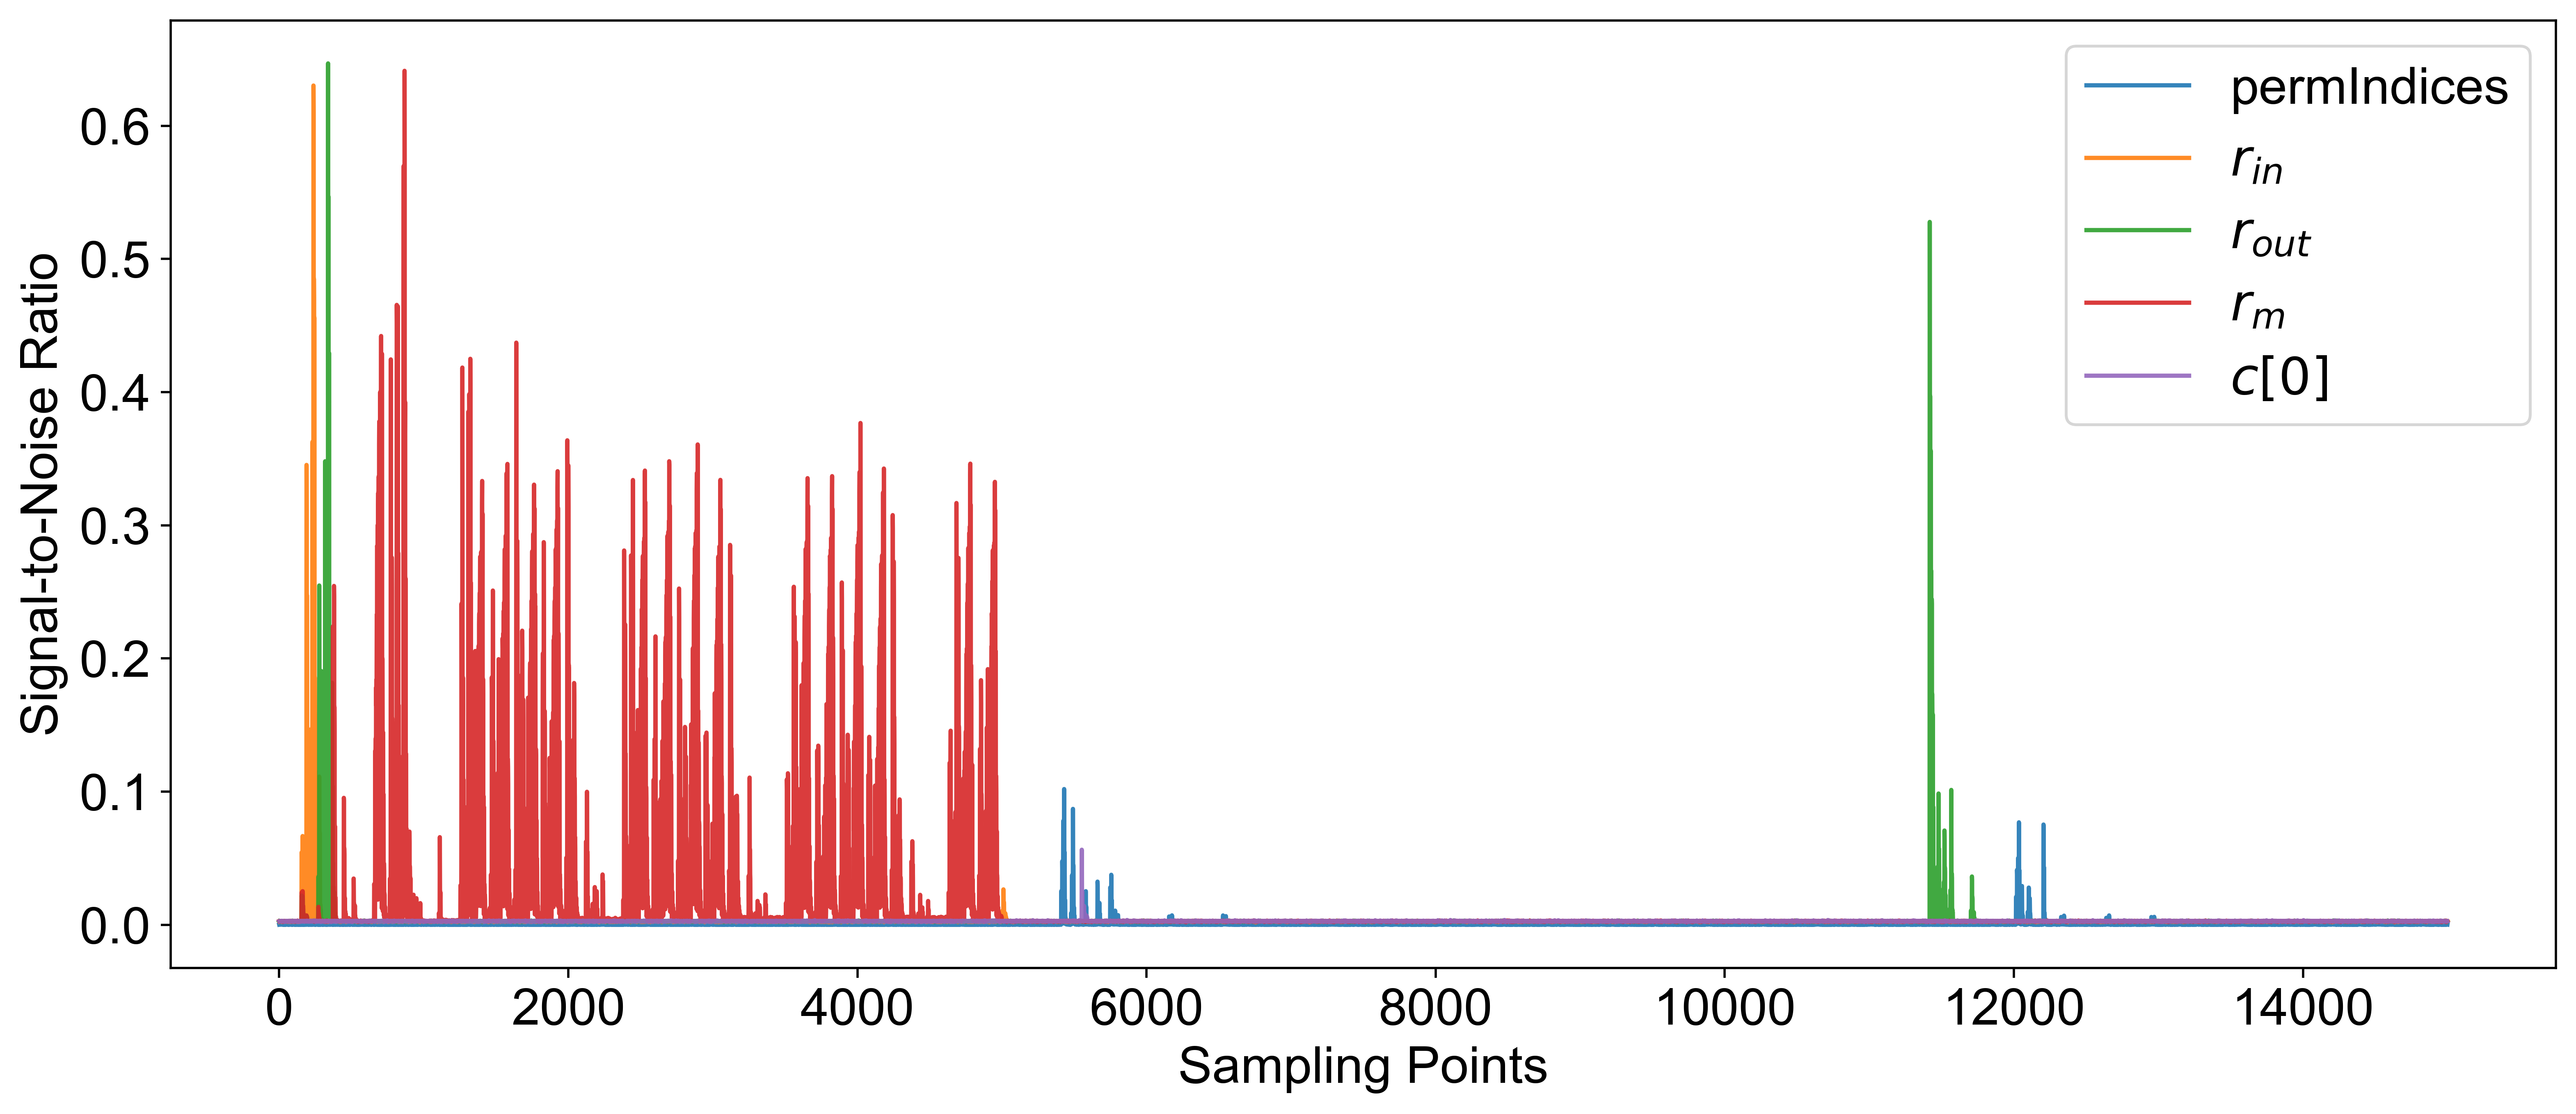

In [15]:
import sys
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import palettable

from Setup import generatePermIndices, RunningSignalToNoiseRatio, multiplyGF256, SBOX, RunningMean

DATA_FILE = "ascadv2-extracted.h5"
file = h5py.File(DATA_FILE, "r")

traces = file["Profiling_traces"]["traces"]
meta = file["Profiling_traces"]["metadata"]

def retrieve_data(index, byte=0):
    
    trace_instance = traces[index]
    mask_values = meta[index]["masks"]
    key_value, plaintext_value = meta[index]["plaintext"], meta[index]["key"]
    substitution = SBOX[key_value ^ plaintext_value]
    indices = generatePermIndices(np.arange(16), *mask_values[:4])
    
    r_input, r_output, r_mask = mask_values[16], mask_values[17], mask_values[18]
    calc_value = multiplyGF256(r_mask, substitution[indices[byte]]) ^ r_output
    return trace_instance, indices, r_input, r_output, r_mask, calc_value

snr_indices_calculator = RunningSignalToNoiseRatio(n_classes=16)
snr_r_input_calculator = RunningSignalToNoiseRatio(n_classes=256)
snr_r_output_calculator = RunningSignalToNoiseRatio(n_classes=256)
snr_r_mask_calculator = RunningSignalToNoiseRatio(n_classes=255)
snr_calc_calculator = RunningSignalToNoiseRatio(n_classes=256)
mean_trace_calculator = RunningMean()

for index in range(100000):
    trace_instance, indices, r_input, r_output, r_mask, calc_value = retrieve_data(index, byte=0)
    sys.stdout.write(f"\r{index}\t")

    snr_indices_calculator.update(trace_instance, indices[0])
    snr_r_input_calculator.update(trace_instance, r_input)
    snr_r_output_calculator.update(trace_instance, r_output)
    snr_r_mask_calculator.update(trace_instance, r_mask - 1)
    snr_calc_calculator.update(trace_instance, calc_value)
    mean_trace_calculator.update(trace_instance)

    del trace_instance, indices, r_input, r_output, r_mask, calc_value

snr_indices = snr_indices_calculator()
snr_r_input = snr_r_input_calculator()
snr_r_output = snr_r_output_calculator()
snr_r_mask = snr_r_mask_calculator()
snr_calc = snr_calc_calculator()
trace_mean = mean_trace_calculator()

plt.rcParams['figure.figsize'] = [16, 4]
plt.rc('font', family='Arial', size='18')

fig = plt.figure(figsize=(15, 6), dpi=500)
plt.xlabel("Sampling Points")
plt.ylabel("Signal-to-Noise Ratio")
plt.plot(snr_indices, alpha=0.9, label="permIndices")
plt.plot(snr_r_input, alpha=0.9, label="$r_{in}$")
plt.plot(snr_r_output, alpha=0.9, label="$r_{out}$")
plt.plot(snr_r_mask, alpha=0.9, label="$r_m$")
plt.plot(snr_calc, alpha=0.9, label="$c[0]$")
plt.legend()
plt.savefig("COMBINED_SNR.jpg")
plt.show()
